In [1]:
import torch
import sys
import pickle as pkl
import random
import copy

from torch import nn
from torch.nn.modules.module import Module
from torch import optim

import numpy as np
import networkx as nx
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import networkx as nx
import scipy.sparse as sp

from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsRestClassifier
from sklearn.metrics import roc_auc_score, accuracy_score, roc_curve, silhouette_score

base_data_path = ''

In [2]:
def pad_features(features, feature_max_len):
    while len(features) < feature_max_len:
        features.append(0)
    if len(features) > feature_max_len:
        features = np.random.choice(
            features,
            size=feature_max_len,
        )
    return features

def parse_index_file(filename):
    """Parse index file."""
    index = []
    for line in open(filename):
        index.append(int(line.strip()))
    return index

def sample_mask(idx, l):
    """Create mask."""
    mask = np.zeros(l)
    mask[idx] = 1
    return np.array(mask, dtype=np.bool)

def load_data(dataset_str):
    # Taken from Kipf and Welling 2016
    names = ['x', 'y', 'tx', 'ty', 'allx', 'ally', 'graph']
    objects = []
    for i in range(len(names)):
        with open(base_data_path + "gcn-master/gcn/data/ind.{}.{}".format(dataset_str, names[i]), 'rb') as f:
            if sys.version_info > (3, 0):
                objects.append(pkl.load(f, encoding='latin1'))
            else:
                objects.append(pkl.load(f))

    x, y, tx, ty, allx, ally, graph = tuple(objects)
    test_idx_reorder = parse_index_file(base_data_path + "gcn-master/gcn/data/ind.{}.test.index".format(dataset_str))
    test_idx_range = np.sort(test_idx_reorder)

    if dataset_str == 'citeseer':
        # Fix citeseer dataset (there are some isolated nodes in the graph)
        # Find isolated nodes, add them as zero-vecs into the right position
        test_idx_range_full = range(min(test_idx_reorder), max(test_idx_reorder)+1)
        tx_extended = sp.lil_matrix((len(test_idx_range_full), x.shape[1]))
        tx_extended[test_idx_range-min(test_idx_range), :] = tx
        tx = tx_extended
        ty_extended = np.zeros((len(test_idx_range_full), y.shape[1]))
        ty_extended[test_idx_range-min(test_idx_range), :] = ty
        ty = ty_extended

    features = sp.vstack((allx, tx)).tolil()
    features[test_idx_reorder, :] = features[test_idx_range, :]
    features = features.todense()
    adj = nx.adjacency_matrix(nx.from_dict_of_lists(graph))

    labels = np.vstack((ally, ty))
    labels[test_idx_reorder, :] = labels[test_idx_range, :]

    idx_test = set(test_idx_range.tolist())
    idx_train = set(list(range(len(y))))
    idx_val = set(list(range(len(y), len(y) + 500)))

    g = nx.from_numpy_matrix(adj.todense())
    for node_idx in g.node():
        if node_idx in idx_test:
            node_type = 'test'
        elif node_idx in idx_train:
            node_type = 'train'
        elif node_idx in idx_val:
            node_type = 'val'
        else:
            node_type = None
        g.node[node_idx]['type'] = node_type
        g.node[node_idx]['features'] = np.array(features[node_idx,:]).tolist()[0]
        g.node[node_idx]['label'] = np.argmax(labels[node_idx,:])
    feature_dim = min(max(dict(g.degree).values()), 30)
    label_list = []
    action_features_list = []
    structural_features_list = []
    for node in g.node:
        action_features_list.append(g.node[node]['features'])
        structural_features_list.append(
            [g.degree(node)] + sorted(pad_features([g.degree(x) for x in g[node]], feature_dim), reverse=True)
        )
        label_list.append(g.node[node]['label'])
    action_features = torch.FloatTensor(action_features_list)
    structural_features = torch.FloatTensor(structural_features_list)
    labels = torch.FloatTensor(label_list)
    return g, action_features, structural_features, labels, list(idx_train), list(idx_test), list(idx_val)

In [3]:
def sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight):
    logsigmoid = nn.LogSigmoid()
    
    emb_v = emb_v.view(emb_u.size()[0], -1, emb_u.size()[1])
    emb_neg = emb_neg.view(emb_u.size()[0], -1, emb_u.size()[1])

    pos = logsigmoid((emb_u.unsqueeze(1) * emb_v).sum(dim=2)).mean()
    neg = logsigmoid(-(emb_u.unsqueeze(1) * emb_neg).sum(dim=2)).mean()
    
    return - (pos + neg)

In [4]:
def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.xavier_uniform_(m.weight)

In [9]:
class SumAggregator(Module):
    '''
    This class does the sampling and aggregating given a set of features

    We store everything except the set of nodes to aggregate on the class

    We pass the nodes (batch, neg samples, etc) to forward
    '''
    def __init__(
        self,
        features,
        feature_dim,
        emb_dim,
        n_nbr_samples,
        g,
        dropout=0.5,
        depth=1,
        batchnorm=True,
    ):
        super(SumAggregator, self).__init__()
        self.feature_dim = feature_dim
        self.depth = depth
        if batchnorm:
            self.fc = nn.Sequential(
                nn.Linear(feature_dim, emb_dim),
                nn.BatchNorm1d(emb_dim),
                nn.Tanh(),
                nn.Dropout(dropout),
            ).cuda()
        else:
            self.fc = nn.Sequential(
                nn.Linear(feature_dim, emb_dim),
                nn.Tanh(),
                nn.Dropout(dropout),
            ).cuda()
        self.features = features
        self.n_nbr_samples = n_nbr_samples
        self.g = g # can be any dict like: {node: collection(nbrs)}
        self.random_ = np.random.choice
        self.set_ = set

    def forward(
        self,
        node_list,
        randomize_features=False,
    ):
        '''
        features is (unique_node_dim by feature_dim)
        mask is     (node_list by unique_node_dim)
        '''
        # samples and node_list are ordered the same
        samples = [
            list(self.random_(
                list(self.g[node]),
                self.n_nbr_samples,
                replace=False,
            )) + [node]
            if len(self.g[node]) >= self.n_nbr_samples else list(self.g[node]) + [node]
            for node in node_list
        ]
        unique_nodes_list = list(set.union(*(self.set_(x) for x in samples)))
        # this helps us keep column indexes straight
        unique_nodes_dict = {node: idx for idx, node in enumerate(unique_nodes_list)}

        # rows: ordered by samples, cols: ordered by unique node idx (vals in unique_nodes_dict)
        mask = torch.zeros(len(samples), len(unique_nodes_list)).cuda()

        row_idxs = []
        col_idxs = []
        # rows are ordered in the same order as the batch
        for node_idx, node_nbrs in enumerate(samples):
            for alter in node_nbrs:
                row_idxs.append(node_idx)
                col_idxs.append(unique_nodes_dict[alter])
        # for all but the outermost call, this self.features is a call to another encoder
        # the smart thing about this design is we only get the 2nd hop nodes we need
        sampled_features = self.fc(self.features(unique_nodes_list))
        #if randomize_features: #  and self.depth > 1:
        #    sampled_features = sampled_features[torch.randperm(sampled_features.size()[0])]
        mask[row_idxs, col_idxs] = 1
        mask = mask.div(mask.sum(dim=1).unsqueeze(1))
        if randomize_features: #  and self.depth > 1:
            mask = mask[torch.randperm(mask.size()[0])]
        return mask.mm(sampled_features)


class EncodingLayer(Module):
    '''
    Forward takes a batch and an aggregator
    It runs one iter of the aggregator and then applies the encoding layer to it
    '''
    def __init__(
        self,
        features,
        feature_dim,
        emb_input_dim,
        emb_dim,
        g,
        agg,
        base_model=None,
        dropout=0.5,
        depth=1,
        batchnorm=True,
    ):
        super(EncodingLayer, self).__init__()
        self.features = features
        self.emb_dim = emb_dim
        self.g = g
        self.agg = agg
        self.depth = depth
        if base_model:
            self.base_model = base_model
        self.fc = nn.Sequential(
            nn.Linear(emb_input_dim, emb_dim),
            nn.BatchNorm1d(emb_dim),
            nn.Tanh(),
            nn.Dropout(dropout),
        ).cuda()


    def forward(self, node_list, randomize_features=False):
        emb = self.agg(
            node_list=node_list,
            randomize_features=randomize_features,
        )
        # ego_features = self.features(node_list)
        #if randomize_features and self.depth > 1:
        #    ego_features = ego_features[torch.randperm(ego_features.size()[0])]
        emb = self.fc(
            # torch.cat((self.fc0(ego_features), emb), dim=1)
            # self.fc0(ego_features) + emb
            emb
        )
        return emb


class Sum2Model(Module):
    def __init__(
        self,
        emb_dim,
        n_nbr_samples1,
        n_nbr_samples2,
        g,
        features,
        hidden_dim=192,
        dropout=0.5,
    ):
        super(Sum2Model, self).__init__()
        self.features = features
        feature_dim = features.size()[1]
        self.agg1 = SumAggregator(
            features=lambda x: features[x],
            feature_dim=feature_dim,
            emb_dim=hidden_dim,
            n_nbr_samples=n_nbr_samples1,
            g=g,
            dropout=dropout,
            batchnorm=True,
        )
        self.enc1 = EncodingLayer(
            features=lambda x: features[x],
            feature_dim=feature_dim,
            emb_input_dim=hidden_dim,
            emb_dim=hidden_dim,
            g=g,
            agg=self.agg1,
            base_model=None,
            depth=2,
            dropout=dropout,
            batchnorm=True,
        )
        self.agg2 = SumAggregator(
            features=lambda x: self.enc1(x),
            feature_dim=hidden_dim,
            emb_dim=hidden_dim,
            n_nbr_samples=n_nbr_samples2,
            g=g,
            dropout=dropout,
            batchnorm=True,
        )
        self.enc2 = EncodingLayer(
            features=lambda x: self.enc1(x),
            feature_dim=hidden_dim,
            emb_input_dim=hidden_dim,
            emb_dim=emb_dim,
            g=g,
            agg=self.agg2,
            base_model=self.enc1,
            depth=1,
            dropout=dropout,
            batchnorm=True,
        )
        self.model = self.enc2.apply(init_weights)

    def forward(self, node_list, randomize_features=False):
        # return self.model(node_list, randomize_features)
        if self.model.training:
            return self.model(node_list, randomize_features)
        else:
            return torch.cat(
                (
                    self.enc2(node_list, False),
                    self.enc1(node_list, False),
                ),
                dim=1,
            )
        

def run_model_within(
    model_class,
    emb_dim,
    n_nbr_samples1,
    n_nbr_samples2,
    n_pos_samples,
    n_neg_samples_rand,
    n_neg_samples_shuffle,
    g,
    features,
    labels,
    train_idx_list,
    test_idx_list,
    lr=0.01,
    n_runs=20,
    n_epochs=20,
    batch_size=256,
    dropout=0.5,
):
    accs = []
    accs_sd = []

    node_list = [x for x in g.node]
    
    for run in range(n_runs):
        model1 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer1 = optim.Adam(
            model1.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model2 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer2 = optim.Adam(
            model2.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        total_loss = 0
        for epoch in range(n_epochs):
            model1 = model1.train()
            model2 = model2.train()
            random.shuffle(node_list)
            batch = node_list[:batch_size]
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            emb_u = model1(batch)
            nbrs = []
            for node in batch:
                for _ in range(n_pos_samples):
                    nbrs.append(node)
                #for _ in range(n_pos_samples):
                #    nbrs.append(random.choice(list(g[node])))
            emb_v = model2(nbrs).view(n_pos_samples * len(batch), -1)
            neg_nodes_shuffle = []
            neg_nodes_rand = []
            for idx, node in enumerate(batch):
                for _ in range(n_neg_samples_shuffle):
                    neg_nodes_shuffle.append(node)
                batch_minus_ego = list(set(batch) - {node}) #  - set(list(g[node])))
                for _ in range(n_neg_samples_rand):
                    neg_nodes_rand.append(
                        random.choice(
                            batch_minus_ego
                        )
                    )
            if len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) > 0:
                emb_neg1 = model2(neg_nodes_shuffle, randomize_features=True)
                emb_neg2 = model2(neg_nodes_rand, randomize_features=False)
                total_neg_samples = n_neg_samples_rand + n_neg_samples_shuffle
                emb_neg = torch.cat((emb_neg1, emb_neg2), dim=1).view(
                    total_neg_samples * len(batch),
                    -1,
                )
            elif len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) == 0:
                emb_neg = model2(neg_nodes_shuffle, randomize_features=True)
            elif len(neg_nodes_shuffle) == 0 and len(neg_nodes_rand) > 0:
                emb_neg = model2(neg_nodes_rand, randomize_features=False)
            pos_weight = emb_neg.numel() / emb_u.numel()
            loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
            total_loss += float(loss.cpu().data.numpy())
            # print(total_loss / (epoch + 1))
            loss.backward()
            optimizer1.step()
            optimizer2.step()
        model1 = model1.eval()
        X_train = model1(train_idx_list).cpu().data.numpy()
        y_train = np.array([labels[idx] for idx in train_idx_list])
        X_test = model1(test_idx_list).cpu().data.numpy()
        y_test = np.array([labels[idx] for idx in test_idx_list])
        logit = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs'))
        logit.fit(X_train, y_train)
        preds = logit.predict(X_test)
        accs.append(accuracy_score(y_test, preds))
        print(run, accuracy_score(y_test, preds))
    return accs, accs_sd


def run_model_between(
    model_class,
    emb_dim,
    n_nbr_samples1,
    n_nbr_samples2,
    n_pos_samples,
    n_neg_samples_rand,
    n_neg_samples_shuffle,
    g,
    features,
    labels,
    train_idx_list,
    test_idx_list,
    lr=0.01,
    n_runs=20,
    n_epochs=20,
    batch_size=256,
    dropout=0.5,
):
    accs = []
    accs_sd = []

    node_list = [x for x in g.node]
    
    for run in range(n_runs):
        model1 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer1 = optim.Adam(
            model1.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model1 = model1.train()
        model2 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer2 = optim.Adam(
            model2.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model2 = model2.train()

        total_loss = 0
        for epoch in range(n_epochs):
            model1 = model1.train()
            model2 = model2.train()
            random.shuffle(node_list)
            batch = node_list[:batch_size]
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            emb_u = model1(batch)
            nbrs = []
            for node in batch:
                for _ in range(n_pos_samples):
                    nbrs.append(random.choice(list(g[node])))
            emb_v = model2(nbrs).view(n_pos_samples * len(batch), -1)
            neg_nodes_shuffle = []
            neg_nodes_rand = []
            for idx, node in enumerate(batch):
                for _ in range(0):
                    neg_nodes_shuffle.append(random.choice(list(g[node])))
                batch_minus_ego = list(set(batch) - {node} - set(list(g[node])))
                for _ in range(n_neg_samples_rand + n_neg_samples_shuffle):
                    neg_nodes_rand.append(
                        random.choice(
                            batch_minus_ego
                        )
                    )
            if len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) > 0:
                emb_neg1 = model2(neg_nodes_shuffle, randomize_features=True)
                emb_neg2 = model2(neg_nodes_rand, randomize_features=False)
                total_neg_samples = n_neg_samples_rand + n_neg_samples_shuffle
                emb_neg = torch.cat((emb_neg1, emb_neg2), dim=1).view(
                    total_neg_samples * len(batch),
                    -1,
                )
            elif len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) == 0:
                emb_neg = model2(neg_nodes_shuffle, randomize_features=True)
            elif len(neg_nodes_shuffle) == 0 and len(neg_nodes_rand) > 0:
                emb_neg = model2(neg_nodes_rand, randomize_features=False)
            pos_weight = emb_neg.numel() / emb_u.numel()
            loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
            total_loss += float(loss.cpu().data.numpy())
            # print(total_loss / (epoch + 1))
            loss.backward()
            optimizer1.step()
            optimizer2.step()
        model1 = model1.eval()
        X_train = model1(train_idx_list).cpu().data.numpy()
        y_train = np.array([labels[idx] for idx in train_idx_list])
        X_test = model1(test_idx_list).cpu().data.numpy()
        y_test = np.array([labels[idx] for idx in test_idx_list])
        logit = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs'))
        logit.fit(X_train, y_train)
        preds = logit.predict(X_test)
        accs.append(accuracy_score(y_test, preds))
        print(run, accuracy_score(y_test, preds))
    return accs, accs_sd


def run_model_both(
    model_class,
    emb_dim,
    n_nbr_samples1,
    n_nbr_samples2,
    n_pos_samples,
    n_neg_samples_rand,
    n_neg_samples_shuffle,
    g,
    features,
    labels,
    train_idx_list,
    test_idx_list,
    lr=0.01,
    n_runs=20,
    n_epochs=20,
    batch_size=256,
    dropout=0.5,
):
    accs = []
    accs_sd = []

    node_list = [x for x in g.node]
    
    for run in range(n_runs):
        model1 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer1 = optim.Adam(
            model1.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model2 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer2 = optim.Adam(
            model2.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        total_loss = 0
        for epoch in range(n_epochs):
            model1 = model1.train()
            model2 = model2.train()
            random.shuffle(node_list)
            batch = node_list[:batch_size]
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            emb_u = model1(batch)
            nbrs = []
            for node in batch:
                for _ in range(n_pos_samples):
                    nbrs.append(node)
                #for _ in range(n_pos_samples):
                #    nbrs.append(random.choice(list(g[node])))
            emb_v = model2(nbrs).view(n_pos_samples * len(batch), -1)
            neg_nodes_shuffle = []
            neg_nodes_rand = []
            for idx, node in enumerate(batch):
                for _ in range(n_neg_samples_shuffle):
                    neg_nodes_shuffle.append(node)
                batch_minus_ego = list(set(batch) - {node}) #  - set(list(g[node])))
                for _ in range(n_neg_samples_rand):
                    neg_nodes_rand.append(
                        random.choice(
                            batch_minus_ego
                        )
                    )
            if len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) > 0:
                emb_neg1 = model2(neg_nodes_shuffle, randomize_features=True)
                emb_neg2 = model2(neg_nodes_rand, randomize_features=False)
                total_neg_samples = n_neg_samples_rand + n_neg_samples_shuffle
                emb_neg = torch.cat((emb_neg1, emb_neg2), dim=1).view(
                    total_neg_samples * len(batch),
                    -1,
                )
            elif len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) == 0:
                emb_neg = model2(neg_nodes_shuffle, randomize_features=True)
            elif len(neg_nodes_shuffle) == 0 and len(neg_nodes_rand) > 0:
                emb_neg = model2(neg_nodes_rand, randomize_features=False)
            pos_weight = emb_neg.numel() / emb_u.numel()
            loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
            total_loss += float(loss.cpu().data.numpy())
            # print(total_loss / (epoch + 1))
            loss.backward()
            optimizer1.step()
            optimizer2.step()
        model_within = model1.eval()
        
        model1 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer1 = optim.Adam(
            model1.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model1 = model1.train()
        model2 = model_class(
            emb_dim=emb_dim,
            n_nbr_samples1=n_nbr_samples1,
            n_nbr_samples2=n_nbr_samples2,
            g=g,
            features=features,
            dropout=dropout,
        )
        optimizer2 = optim.Adam(
            model2.parameters(),
            lr=lr,
            #weight_decay=1e-5,
        )
        model2 = model2.train()

        total_loss = 0
        for epoch in range(n_epochs):
            model1 = model1.train()
            model2 = model2.train()
            random.shuffle(node_list)
            batch = node_list[:batch_size]
            optimizer1.zero_grad()
            optimizer2.zero_grad()
            emb_u = model1(batch)
            nbrs = []
            for node in batch:
                for _ in range(n_pos_samples):
                    nbrs.append(random.choice(list(g[node])))
            emb_v = model2(nbrs).view(n_pos_samples * len(batch), -1)
            neg_nodes_shuffle = []
            neg_nodes_rand = []
            for idx, node in enumerate(batch):
                for _ in range(0):
                    neg_nodes_shuffle.append(random.choice(list(g[node])))
                batch_minus_ego = list(set(batch) - {node} - set(list(g[node])))
                for _ in range(n_neg_samples_rand + n_neg_samples_shuffle):
                    neg_nodes_rand.append(
                        random.choice(
                            batch_minus_ego
                        )
                    )
            if len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) > 0:
                emb_neg1 = model2(neg_nodes_shuffle, randomize_features=True)
                emb_neg2 = model2(neg_nodes_rand, randomize_features=False)
                total_neg_samples = n_neg_samples_rand + n_neg_samples_shuffle
                emb_neg = torch.cat((emb_neg1, emb_neg2), dim=1).view(
                    total_neg_samples * len(batch),
                    -1,
                )
            elif len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) == 0:
                emb_neg = model2(neg_nodes_shuffle, randomize_features=True)
            elif len(neg_nodes_shuffle) == 0 and len(neg_nodes_rand) > 0:
                emb_neg = model2(neg_nodes_rand, randomize_features=False)
            pos_weight = emb_neg.numel() / emb_u.numel()
            loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
            total_loss += float(loss.cpu().data.numpy())
            # print(total_loss / (epoch + 1))
            loss.backward()
            optimizer1.step()
            optimizer2.step()
        model_between = model1.eval()
        
        X_train = torch.cat(
            (
                model_within(train_idx_list),
                model_between(train_idx_list)
            ),
            dim=1
        ).cpu().data.numpy()
        y_train = np.array([labels[idx] for idx in train_idx_list])
        X_test = torch.cat(
            (
                model_within(test_idx_list),
                model_between(test_idx_list)
            ),
            dim=1
        ).cpu().data.numpy()
        y_test = np.array([labels[idx] for idx in test_idx_list])
        logit = OneVsRestClassifier(LogisticRegression(penalty='l2', solver='lbfgs'))
        logit.fit(X_train, y_train)
        preds = logit.predict(X_test)
        accs.append(accuracy_score(y_test, preds))
        print(run, accuracy_score(y_test, preds))
    return accs, accs_sd

## Node classif

In [25]:
g, action_features, structural_features, labels, idx_train, idx_test, idx_val = load_data('cora')

## Untrained

In [11]:
untrained_accs, untrained_accs_sd = run_model_within(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=0,
    n_neg_samples_shuffle=20,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=0,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

0 0.598
1 0.573
2 0.559
3 0.57
4 0.525
5 0.611
6 0.608
7 0.615
8 0.56
9 0.597
10 0.591
11 0.54
12 0.567
13 0.547
14 0.583
15 0.539
16 0.55
17 0.562
18 0.527
19 0.58


In [36]:
print(np.mean(untrained_accs), np.std(untrained_accs))

0.5700999999999999 0.026776668948918923


## Only shuffling

In [21]:
shuffle_accs, shuffle_accs_sd = run_model_within(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=0,
    n_neg_samples_shuffle=20,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=200,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

0 0.766
1 0.776
2 0.781
3 0.791
4 0.779
5 0.778
6 0.764
7 0.758
8 0.774
9 0.753
10 0.771
11 0.775
12 0.769
13 0.786
14 0.8
15 0.786
16 0.773
17 0.781
18 0.771
19 0.772


In [33]:
print(np.mean(shuffle_accs), np.std(shuffle_accs))

0.7752000000000001 0.010670520137275416


## No shuffling

In [22]:
no_shuffle_accs, no_shuffle_accs_sd = run_model_within(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=20,
    n_neg_samples_shuffle=0,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=200,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

0 0.789
1 0.754
2 0.785
3 0.76
4 0.772
5 0.772
6 0.779
7 0.796
8 0.795
9 0.781
10 0.767
11 0.767
12 0.756
13 0.777
14 0.766
15 0.781
16 0.779
17 0.792
18 0.774
19 0.779


In [34]:
print(np.mean(no_shuffle_accs), np.std(no_shuffle_accs))

0.77605 0.01179607985730854


## Within

In [ ]:
within_accs, within_accs_sd = run_model_within(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=10,
    n_neg_samples_shuffle=10,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=200,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

0 0.775
1 0.783
2 0.787


In [31]:
print(np.mean(within_accs), np.std(within_accs))

0.7795000000000001 0.009457801012920507


## Between

In [ ]:
between_accs, between_accs_sd = run_model_between(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=20,
    n_neg_samples_shuffle=0,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=200,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

In [35]:
print(np.mean(between_accs), np.std(between_accs))

0.79305 0.012338861373724882


## Both

In [26]:
both_accs, both_accs_sd = run_model_both(
    model_class=Sum2Model,
    emb_dim=64,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    n_pos_samples=5,
    n_neg_samples_rand=10,
    n_neg_samples_shuffle=10,
    g=g,
    features=action_features.cuda(),
    labels=labels,
    train_idx_list=idx_train,
    test_idx_list=idx_test,
    lr=0.01,
    n_epochs=200,
    batch_size=256,
    dropout=0.6,
    n_runs=20,
)

0 0.802
1 0.802
2 0.806
3 0.806
4 0.805
5 0.801
6 0.804
7 0.8
8 0.8
9 0.803
10 0.791
11 0.804
12 0.805
13 0.806
14 0.797
15 0.784
16 0.792
17 0.799
18 0.821
19 0.806


In [32]:
print(np.mean(both_accs), np.std(both_accs))

0.8017 0.007204859471218012


## Visualize

In [40]:
node_list = [x for x in g.node]
n_pos_samples = 5
n_neg_samples_rand = 10
n_neg_samples_shuffle = 10
emb_dim = 64
lr = 0.01

model1 = Sum2Model(
    emb_dim=emb_dim,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    g=g,
    features=action_features.cuda(),
    dropout=0.6,
)
optimizer1 = optim.Adam(
    model1.parameters(),
    lr=lr,
)
model2 = Sum2Model(
    emb_dim=emb_dim,
    n_nbr_samples1=25,
    n_nbr_samples2=10,
    g=g,
    features=action_features.cuda(),
    dropout=0.6,
)
model2 = model1
optimizer2 = optim.Adam(
    model2.parameters(),
    lr=lr,
)
total_loss = 0
for epoch in range(200):
    model1 = model1.train()
    model2 = model2.train()
    random.shuffle(node_list)
    batch = node_list[:256]
    optimizer1.zero_grad()
    optimizer2.zero_grad()
    emb_u = model1(batch)
    nbrs = []
    for node in batch:
        for _ in range(n_pos_samples):
            nbrs.append(node)
        #for _ in range(n_pos_samples):
        #    nbrs.append(random.choice(list(g[node])))
    emb_v = model2(nbrs).view(n_pos_samples * len(batch), -1)
    neg_nodes_shuffle = []
    neg_nodes_rand = []
    for idx, node in enumerate(batch):
        for _ in range(n_neg_samples_shuffle):
            neg_nodes_shuffle.append(node)
        batch_minus_ego = list(set(batch) - {node}) #  - set(list(g[node])))
        for _ in range(n_neg_samples_rand):
            neg_nodes_rand.append(
                random.choice(
                    batch_minus_ego
                )
            )
    if len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) > 0:
        emb_neg1 = model2(neg_nodes_shuffle, randomize_features=True)
        emb_neg2 = model2(neg_nodes_rand, randomize_features=False)
        total_neg_samples = n_neg_samples_rand + n_neg_samples_shuffle
        emb_neg = torch.cat((emb_neg1, emb_neg2), dim=1).view(
            total_neg_samples * len(batch),
            -1,
        )
    elif len(neg_nodes_shuffle) > 0 and len(neg_nodes_rand) == 0:
        emb_neg = model2(neg_nodes_shuffle, randomize_features=True)
    elif len(neg_nodes_shuffle) == 0 and len(neg_nodes_rand) > 0:
        emb_neg = model2(neg_nodes_rand, randomize_features=False)
    pos_weight = emb_neg.numel() / emb_u.numel()
    loss = sigmoid_loss(emb_u, emb_v, emb_neg, pos_weight)
    total_loss += float(loss.cpu().data.numpy())
    # print(total_loss / (epoch + 1))
    loss.backward()
    optimizer1.step()
    optimizer2.step()
model1 = model1.eval()
emb1 = model1(node_list)

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

df = pd.DataFrame(TSNE(n_components=2).fit_transform(emb1.cpu().data.numpy()))

df['label'] = [labels[x] for x in node_list]

df.columns = ['x', 'y', 'label']
# output['color'] = [current_palette[colors[g.node[idx]['label']]] for idx in node_list]

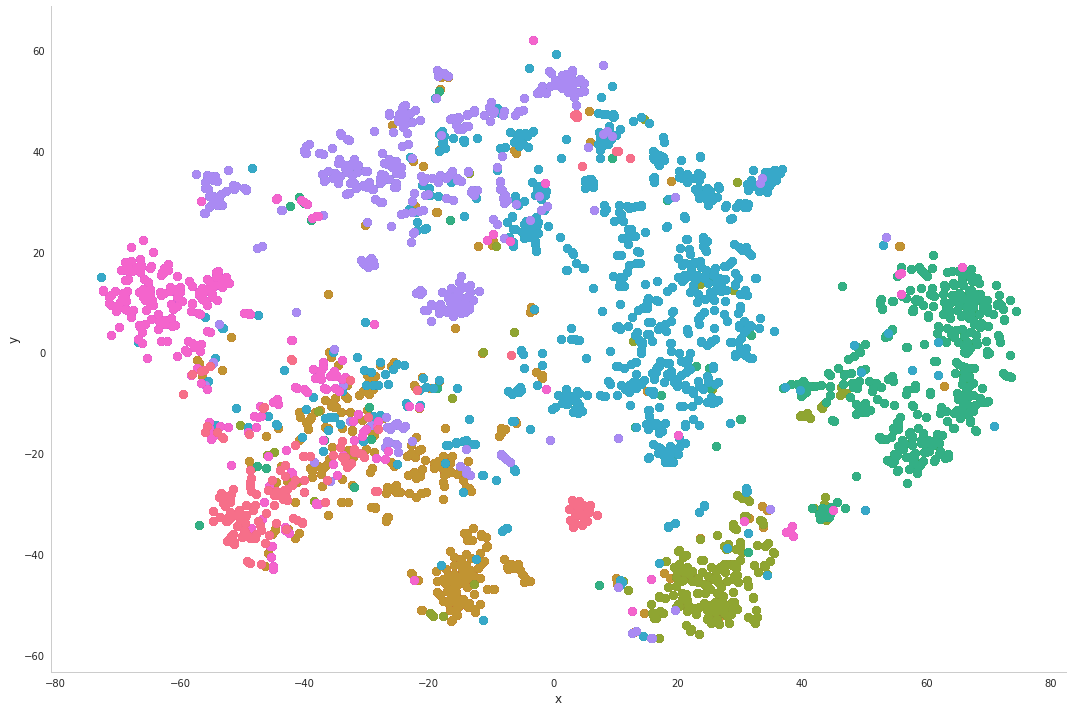

In [41]:
sns.set_style("whitegrid", {'axes.grid' : False})
sns.lmplot(
    x='x',
    y='y',
    data=df,
    fit_reg=False,
    hue='label',
    legend=False,
    height=10,
    aspect=1.5,
    scatter_kws={"s": 50},
)
plt.show()

In [42]:
silhouette_score(df[['x', 'y']], [labels[x] for x in node_list])

0.16594297